# CDS data transformation

We want to get SST data from CDS and transform it to a single timeseries per survey site, i.e., one CSV per site.  
The steps we have to take are:
* set things up
* download data for each site (grid tile, actually)
* extract & convert from netcdf format to CSV

---

This notebook was developed for Google Colab. Most data wrangling code blocks are finalized by another block, that stores the data to Google Drive. There's a couple of ways you can run this:
* You can run this notebook as-is on Colab. 
* If you have a decent OS, you should be able to mount your desired storage to the location given below. 
* There may be some drop-in replacements for the `google.colab.drive` import. 
* If you don't want/need to store the data externally, you can just uncomment the corresponding code blocks (and tweak the code where necessary).

Colab also comes with a bunch of Python packages preinstalled. If you don't run on Colab you'll have to install them first (see imports below).

## Imports, initialization

While there are Python packages for manipulating netcdf files, we'll also use the corresponding CLI version as it's easy and handy to switch between shell and Python in notebooks and some things are easier in one or the other.

In [ ]:
!touch ~/.cdsapirc
!pip install cdsapi netcdf4 cdo basemap basemap-data-hires
!apt install -y --no-install-recommends -q cdo
!if [ -d sample_data ]; then rm -rf sample_data; fi # colab only

In [18]:
import os
import cdsapi
import pandas as pd
import urllib3
import netCDF4
from IPython.display import Markdown as md
from cdo import Cdo
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
import numpy as np
from pathlib import Path
import concurrent.futures
import shutil
from decimal import Decimal

Let's define some constants for some working directories and create them:

In [3]:
DIR_DL = 'cds_dl'               # where we download to  
DIR_TRANSF = 'extracted'        # where we store the transformed data
DIR_OUT = 'csv'                 # initial CSV dump location
DIR_OUT_INLINE = 'csv_inlined'  # directory for final output
DIR_TILES = 'tiles'             # where we store the tiles separately

In [27]:
%%bash -s "$DIR_DL" "$DIR_TRANSF" "$DIR_OUT" "$DIR_OUT_INLINE" "$DIR_TILES"
mkdir -p $@

The CDS API requires an API key. Create one at https://cds.climate.copernicus.eu/user/register  
Then generate an API key in your settings and past it into the prompt below:

In [ ]:
# write API key etc
api_key = input()
with open('/root/.cdsapirc', 'w+') as f:
    content = f'''
url: https://cds.climate.copernicus.eu/api/v2
key: {api_key}
verify: 0
'''
    f.write(content)

urllib3.disable_warnings()

> When you share this notebook, remember to clear your API token from the output above!

In [ ]:
# mount gdrive if running in colab
IN_COLAB = False
try:
    from google.colab import drive
    drive.mount("/content/data")
    print("drive mounted")
    IN_COLAB = True
except:
    print("not running in colab")
    os.mkdir("data")

In [28]:
%%bash -s "$DIR_OUT" "$DIR_OUT_INLINE" "$DIR_TRANSF" "$DIR_TILES"
# restore data from colab
if [ -d data/MyDrive/cds_data/csv ]; then
    #cp -r -u data/MyDrive/cds_data/csv/* "${1}/" 
    cp -r -u data/MyDrive/cds_data/csv_inlined/* "${2}/"
    cp -r -u data/MyDrive/cds_data/sst/extracted/* "${3}/"
    cp -r -u data/MyDrive/cds_data/sst/tiles/* "${4}/"
fi

## lat/lon grid cells

The CDS SST data is gridded with `.05` grid span. The API requires the NW and SE corner of a tile. We need some utility functions to translate between our survey site coordinates and the corners of the grid tile our sites lie within.

How do we calculate the bounds of the rect (well, the *geographic rectangle*)? The grid starts at $(0,0)$, so we just have to find the next lower and uppter integer multiple to our coordinate. Say we have a latitude of `14.333`, then the lower and upper tile latitudes are `14.30` and `14.35`.

Pythons modulo `%` will have the same sign as the "divisor", so for negative divisors we'll flip its sign. On the southern hemisphere, the *northern* bound is the the greater one (negative, closer to zero). With eastern longitude, the *western* bound is the lower one (positive, closer to zero).

In [77]:
def get_bounds(p, grid_spacing=.05, decimals=2): # with type hints: :float, :float, :int -> tuple[float, float]
    '''get lower and upper corner - stripped to n decimals'''
    if p < 0:
        grid_spacing = -grid_spacing
    lower = p - (p % grid_spacing)
    return float(f"{lower:.{decimals}f}"), float(f"{(lower + grid_spacing):.{decimals}f}")
 
def get_bounds_str(p, grid_spacing=.05, decimals=2): # with type hints: :float, :float, :int -> tuple[str, str]
    '''get_bounds and format to n decimals'''
    x = get_bounds(p, grid_spacing)
    return f"{x[0]:.{decimals}f}", f"{x[1]:.{decimals}f}"
	
def get_corners(lat, lon, grid_spacing=.05, decimals=2):
    '''get the NW and SE corners of the according grid tile'''
    lat_bounds = get_bounds(lat, grid_spacing, decimals)
    lon_bounds = get_bounds(lon, grid_spacing, decimals)
    return (lat_bounds[0], lon_bounds[0]), (lat_bounds[1], lon_bounds[1])
 
def get_bounds_acc(p, grid_spacing=.05, decimals=2):
    '''
	get lower and upper corner - stripped to n decimals
	
	compared to get_bounds() this version avoids floating point
	rounding errors around the edges
	'''
    if p < 0:
        grid_spacing = -grid_spacing
    # to Decimal to avoid float rounding errors
    lower = Decimal(str(p))
    grid_spacing = Decimal(str(grid_spacing))
    lower = lower - (lower % grid_spacing)
    return float(f"{lower:.{decimals}f}"), float(f"{(lower + grid_spacing):.{decimals}f}")

Comparison between the two calculations: `get_bounds()` will assign `n * grid_spacing` to the "left" cell, whereas `get_bounds_acc()` will assign it to the next one.

In [5]:
# test
test_data = [1, 1.00, 1.001, 0.9999, 0.959, 14.22, 15.12345, -16.88888, 0]
(
    list(map(lambda x: get_bounds(x), test_data)),
    list(map(lambda x: get_bounds_acc(x), test_data))
)

([(0.95, 1.0),
  (0.95, 1.0),
  (1.0, 1.05),
  (0.95, 1.0),
  (0.95, 1.0),
  (14.2, 14.25),
  (15.1, 15.15),
  (-16.85, -16.9),
  (0.0, 0.05)],
 [(1.0, 1.05),
  (1.0, 1.05),
  (1.0, 1.05),
  (0.95, 1.0),
  (0.95, 1.0),
  (14.2, 14.25),
  (15.1, 15.15),
  (-16.85, -16.9),
  (0.0, 0.05)])

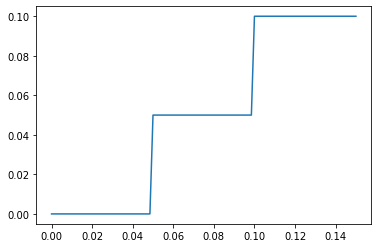

In [6]:
f = lambda x: get_bounds(x)[0]
x = np.linspace(0,0.15,100)
y = list(map(f, x))
plt.plot(x, y)
plt.show()

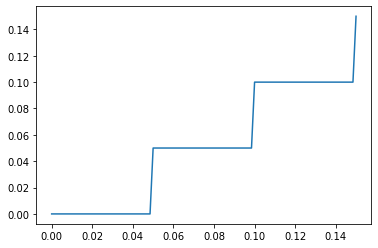

In [7]:
f = lambda x: get_bounds_acc(x)[0]
x = np.linspace(0,0.15,100)
y = list(map(f, x))
plt.plot(x, y)
plt.show()

## Fetch survey sites' lat/lon coords

Download the site coordinates from the GH repo.

In [ ]:
!wget -O survey_coordinates.csv https://raw.githubusercontent.com/codymoly/msc_thesis/main/data/survey_coordinates_2019_2022.csv

In [15]:
coordinates = pd.read_csv('survey_coordinates.csv')
coordinates

,latitude,longitude
0,-12.22,123.00
1,-12.24,122.99
2,-12.24,122.98
3,-10.43,105.67
4,-11.97,123.32
...,...,...
692,-43.40,147.10
693,-43.39,147.10
694,-43.48,147.01
695,-43.41,147.10


We'll use the NW corner of the corresponding grid cell to identify the cell later, so let's compute it now and add it to the dataframe.

In [16]:
# from grid cells to sites - enhance coords with nw corner munched together
def row_to_corner_fname(row):
    x = get_corners(row['latitude'], row['longitude'])[0]
    return f"{x[0]}_{x[1]}"

coordinates['nw'] = coordinates.apply(row_to_corner_fname, axis=1) 
coordinates

,latitude,longitude,nw
0,-12.22,123.00,-12.2_122.95
1,-12.24,122.99,-12.2_122.95
2,-12.24,122.98,-12.2_122.95
3,-10.43,105.67,-10.4_105.65
4,-11.97,123.32,-11.95_123.3
...,...,...,...
692,-43.40,147.10,-43.35_147.05
693,-43.39,147.10,-43.35_147.05
694,-43.48,147.01,-43.45_147.0
695,-43.41,147.10,-43.4_147.05


We define our whole survey area as two coordinate tuples (NW and SE corner).

In [17]:
lat_n, _ = get_bounds(coordinates['latitude'].max()) # southern hemi
_, lat_s = get_bounds(coordinates['latitude'].min()) # southern hemi
lon_w, _ = get_bounds(coordinates['longitude'].min()) # east
_, lon_e = get_bounds(coordinates['longitude'].max()) # east

nw_corner = (lat_n, lon_w)
se_corner = (lat_s, lon_e)
ne_corner = (lat_n, lon_e)
sw_corner = (lat_s, lon_w)

SURVEY_AREA = [nw_corner, se_corner]
SURVEY_AREA

[(-9.85, 105.65), (-43.55, 168.0)]

## Visualize

Always a good idea.

In [21]:
# https://stackoverflow.com/a/50542699
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = Polygon(list(xy), facecolor='red', alpha=0.3)
    plt.gca().add_patch(poly)

lats = [ SURVEY_AREA[0][0], SURVEY_AREA[1][0], SURVEY_AREA[1][0], SURVEY_AREA[0][0] ]
lons = [ SURVEY_AREA[0][1], SURVEY_AREA[0][1], SURVEY_AREA[1][1], SURVEY_AREA[1][1] ]

Let's see where our sites are and how big the survey area is. Use a topological map as sanity check (reefs shouldn't be super deep, should they?).

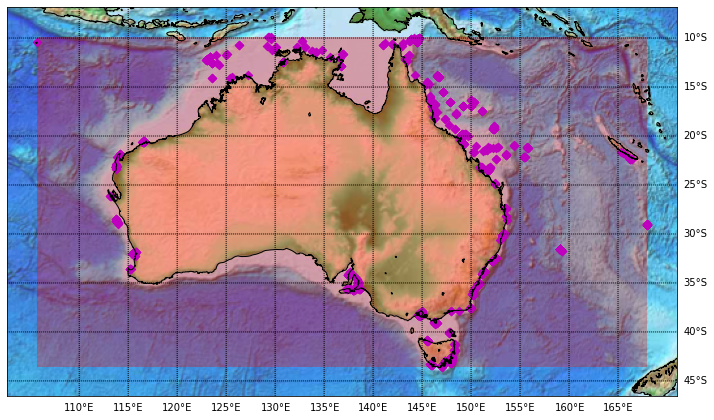

In [22]:
fig = plt.figure(figsize=(12, 12))
margin = 3
m = Basemap(
    projection='cyl',
    resolution='i',
    lat_0=(lat_n + lat_s) / 2,
    lon_0=(lon_w + lon_e) / 2,
    urcrnrlon=lon_e + margin, urcrnrlat=lat_n + margin,
    llcrnrlon=lon_w - margin, llcrnrlat=lat_s - margin, 
)
m.etopo(scale=0.5, alpha=0.8)
m.drawcoastlines()
draw_screen_poly(lats, lons, m)
x, y = m(coordinates['longitude'], coordinates['latitude'])
m.scatter(x, y, marker='D',color='m')

m.drawparallels(np.arange(-50., 0., 5.), labels=[False, True, True, False]) # lats
m.drawmeridians(np.arange(110., 170., 5.), labels=[True, False, False, True])

plt.show()

Let's see how far off the NW grid tile corners are from the actual survey sites. Zoom in on a sample in the north east.

Actually, it doesn't really matter how far away they are from the NW corner, this is just a sanity check. The SST data is averaged and/or interpolated, so, if anything, the center of a tile should be the most accurate.

Corners are in magenta and on the grid, sites in cyan.

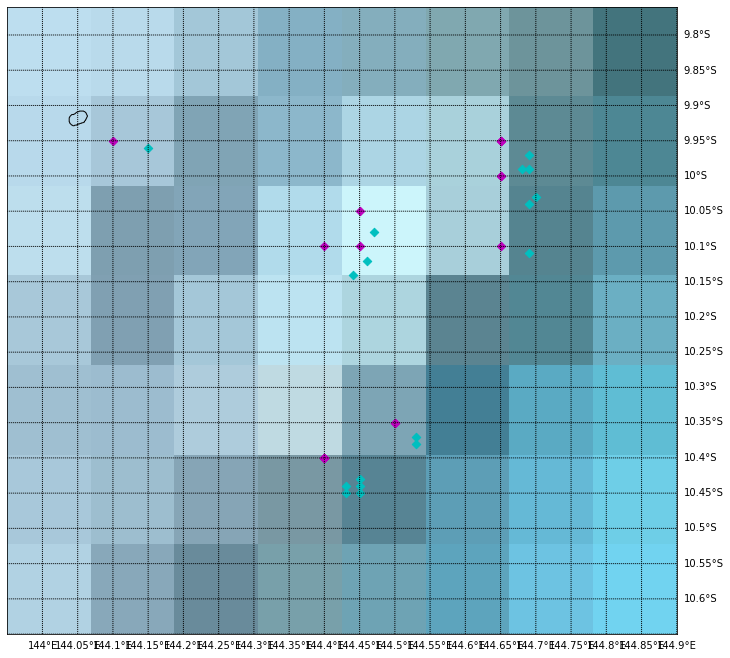

In [85]:
def get_lower_v(p, grid_spacing=.05):
    if p < 0:
        grid_spacing = -grid_spacing
    return p - (p % grid_spacing)

sub = coordinates[(coordinates['longitude'] > 144) & (coordinates['latitude'] > -10.5)]
sub_x = sub['longitude']
sub_y = sub['latitude']

fig = plt.figure(figsize=(12, 12))
margin = .2
m = Basemap(
    projection='cyl',
    resolution='f',
    lat_0=(sub_y.max() + sub_y.min()) / 2,
    lon_0=(sub_x.max() + sub_x.min()) / 2,
    urcrnrlon=sub_x.max() + margin, urcrnrlat=sub_y.max() + margin,
    llcrnrlon=sub_x.min() - margin, llcrnrlat=sub_y.min() - margin, 
)
m.etopo(scale=0.5, alpha=0.8)
m.drawcoastlines()
x, y = m(sub_x.apply(get_lower_v), sub_y.apply(get_lower_v))
m.scatter(x, y, marker='D', color='m')
m.scatter(sub['longitude'], sub['latitude'], marker='D', color='c')

m.drawparallels(np.arange(-50., 0., .05), labels=[False, True, True, False]) # lats
m.drawmeridians(np.arange(110., 170., .05), labels=[True, False, False, True])

plt.show()

## Download copernicus data

The SST data has a lower resolution than our survey. So some sites will lie within the same grid tile. Hence, some grid tiles will only have to be downloaded once (which is good, for the download is super slow).

In [23]:
num_sites = len(coordinates)
grid_cells = set()
for i, row in coordinates.iterrows():
    nw_corner = get_corners(row["latitude"], row["longitude"])[0]
    grid_cells.add(nw_corner)
num_cells = len(grid_cells)
md(f"We got {num_sites} sites, and {num_cells} distinct grid cells, ratio: {num_cells/num_sites:.2f}")

We got 697 sites, and 399 distinct grid cells, ratio: 0.57

In [ ]:
cdsapi_client = cdsapi.Client()

For manual testing of the API yo can use this verbose version:

```python
cdsapi_client.retrieve(
    'satellite-sea-surface-temperature',
    {
        'version': '2_1',
        'variable': ['analysed_sst', 'analysed_sst_uncertainty'],
        'format': 'zip',
        'processinglevel': 'level_4',
        'sensor_on_satellite': 'combined_product',
        'year': '2009',
        'month': [ # only one month at a time possible
            '01', #'02', '03',
            #'04', '05', '06',
            #'07', '08', '09',
            #'10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'area': [ # NW / SE
            -6.5, 102.25,
            -47.4, 171
        ],
    },
    'aus_jan.zip'
) 
# whole aus area: -6.5, 102.25, -47.4, 171
```

In [ ]:
def download_data(year, months, days, nw_corner, se_corner, filename, client):
    '''
    download sst for given location and date range

    params:
      year      - single year str or int
      months    - range of int 1-12
      days      - range of int 1-31
      nw_corner - tuple[float, float] nw corner of the area
      se_corner - tuple[float, float] se corner of the area
      filename  - where to store the zip file
      client    - the (initialized) client to use
    '''
    return client.retrieve(
        'satellite-sea-surface-temperature',
        {
            'version': '2_1',
            'variable': ['analysed_sst', 'analysed_sst_uncertainty'],
            'format': 'zip',
            'processinglevel': 'level_4',
            'sensor_on_satellite': 'combined_product',
            'year': str(year),
            'month':  list(map(lambda x: f"{x:02d}", months))
            ,
            'day': list(map(lambda x: f"{x:02d}", days)),
            'area': [
                nw_corner[0], nw_corner[1],
                se_corner[0], se_corner[1]
            ],
        },
        filename
    )

In [ ]:
def download_cell(cell_corners, api_client, dl_dir):
    '''
    parallelized download

    parameters:
    - cell: tuple (nw/se) of lat/lon tuples of the grid cell corners to fetch
    - api_client: client to use
    - dl_dir: directory to download to
    '''
    nw = cell_corners[0]
    se = cell_corners[1]
    dl_tasks = []
    dirname = f"{dl_dir}/{nw[0]}_{nw[1]}"
    if not Path(dirname).exists():
        os.mkdir(dirname)

    for year in range(2009, 2022 + 1):
        for month in range(1, 12 + 1):
            if year == 2022 and month > 10: # break after Oct 2022
                continue

            to_name = f"{dirname}/{year}_{month}.zip"
            # skip if already downloaded
            if Path(to_name).is_file():
                continue
            dl_tasks.append({
                "year": year,
                "month": month,
                "nw": nw,
                "se": se,
                "path": to_name
            })

    def dl(task):
        print(f"fetching {task['year']}-{task['month']} to {task['path']}")
        download_data(
            task['year'],
            range(task['month'], task['month'] + 1),
            range(1, 31 + 1),
            task['nw'],
            task['se'],
            task['path'],
            api_client
        )
        print(f"{task['path']}")

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as exector: 
        futures = exector.map(dl, dl_tasks)
    return futures

### Paralellized download

The CDS API only allows us to download the data for one month at a time, and it is awfully slow but it doesn't get slower under some load. So let's do the monthly downloads for each site in parallel (well, concurrently). Ten workes will bring a ~10x speed-up.

In [ ]:
IDX = 1
nw, se = get_corners(coordinates['latitude'][IDX].item(), coordinates['longitude'][IDX].item())
CELL = f"{nw[0]}_{nw[1]}"

In [ ]:
# find next tile we haven't yet downloaded
for i, row in coordinates.iterrows():
    # skip if csv already there
    if Path(f"{DIR_OUT_INLINE}/{row['latitude']:.2f}_{row['longitude']:.2f}.csv").is_file():
        continue
    # skip if transformed data already there
    if Path(f"{DIR_TRANSF}/{row['nw']}/selected.nc").is_file():
        continue
    IDX = i
    nw, se = get_corners(coordinates['latitude'][IDX].item(), coordinates['longitude'][IDX].item())
    CELL = f"{nw[0]}_{nw[1]}"
    break

print(IDX, nw, se, row['latitude'], row['longitude'], f"{nw[0]:.2f}_{nw[1]:.2f}", len(coordinates[coordinates['nw'] == f"{nw[0]}_{nw[1]}"]))

In [ ]:
_ = download_cell((nw, se), cdsapi_client, DIR_DL)

In [ ]:
# if you want to store the intermediate files, too, uncomment:

#%%bash -s "$DIR_DL"
# store to drive
#if [ -d data/MyDrive/cds_data ]; then
#    mkdir -p data/MyDrive/cds_data/sst/
#    cp -n "${1}"/*.zip data/MyDrive/cds_data/sst/
#fi

## Convert netcdf to CSV

The API delivers zip files containing NetCDF (v4) files. While they good for large/sparse and comples data, they are unhandy for such a simple case as our. And we have tons of them but would like to have a single CSV file per site.

So, *transform and roll out*!

Unzip files

In [ ]:
%%bash -s "$DIR_DL" "$CELL"
T="${1}/${2}/"
echo $T
cd $T
unzip "*.zip"
cd -
find "${1}/${2}/" -type f -name *.nc | wc -l

Rename files - we want the date part such that lexical order is temporal order. We could deal with the time series being out of order downstream, but why not fix it right here at the source?

In [ ]:
%%bash -s "$DIR_DL" "$CELL"
for i in "$1/$2/"*.nc; do
    # e.g. cds_dl/eafb0de2-10c5-4a68-b05b-69e482b6db4f-20090327120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR2_area_subset.nc
    newname=$(echo "$i" | sed -r 's|(.*/).*-(20[0-9]{6,})-.*\.nc|\1\2.nc|')
    mv "$i" "${newname}"
done

### concat & select

We have to concatenate the bazillion of cdf files first. We tell `cdo` to compress the file (they'll bloat otherwise) and force 32 bit floats (we ran into some issues where some files had differen float widths).

In [ ]:
!mkdir -p "{DIR_TRANSF}/{CELL}"
!cdo -O -z zip_1 -b F32 --sortname cat "{DIR_DL}/{CELL}/"*.nc "{DIR_TRANSF}/{CELL}/concatenated.nc"

Lil' sanity check.

In [ ]:
!cdo showattsvar "{DIR_TRANSF}/{CELL}/concatenated.nc"

Besides the date, we only need the SST and the uncertainty. Let's drop the rest, so that the files get smaller.

In [ ]:
!cdo select,name=analysed_sst,analysed_sst_uncertainty {DIR_TRANSF}/{CELL}/concatenated.nc {DIR_TRANSF}/{CELL}/selected.nc

In [ ]:
%%bash -s "$DIR_TRANSF"
# store to drive
if [ -d data/MyDrive/cds_data ]; then
    mkdir -p "data/MyDrive/cds_data/sst"
    cp -r -u "${1}"/ data/MyDrive/cds_data/sst/
fi

### to CSV

Now turn the concatenated and selected cdf file and turn it into a CSV. The uncertainty in the cds is in a separate row, which isn't too helpful and wastes space. We'll inline it with the SST, i.e., move it into its own column.

In [ ]:
cdo = Cdo()
cdo.outputtab("date,value,name", input=f"-selname,analysed_sst,analysed_sst_uncertainty {DIR_TRANSF}/{CELL}/selected.nc > {DIR_TRANSF}/{CELL}/selected.tsv")

In [ ]:
def inline_csv(input, output):
    '''
    inline "long format" uncertainty and SST, s.t. there's one row per day
    '''
    # header starts with #\t and messes up stuff - skip and provide names
    df = pd.read_csv(input, sep='\s+', names=['date','value','name'], header=None, skiprows=1)
    # drop dupes - for some reason there are some sometimes ...
    df = df[~df.duplicated()]
    # inline values per date
    new_df = df[df['name'] == 'analysed_sst'] \
        .reset_index(drop=True) \
        .rename(columns={'value': 'analysed_sst', 'name': 'analysed_sst_uncertainty'})
    new_df['analysed_sst_uncertainty'] = df[df['name'] == 'analysed_sst_uncertainty']['value'].to_numpy()
    # write
    new_df.to_csv(output, index=False)

Remember how we said that we may have several sites per grid tile? Now is the time to reap what we sowed - we'll write the same final CSV for each site that's in the same grid tile.

We write to a "tile file" first and then copy it to each corresponding site.

In [ ]:
# write inlined CSVs
tile_file = None
for i, row in coordinates[coordinates['nw'] == CELL].iterrows():
    from_name = f"{DIR_TRANSF}/{row['nw']}/selected.tsv"

    # write to tiles
    if tile_file == None:
        tile_file = f"{DIR_TILES}/{row['nw']}.csv"
        inline_csv(from_name, tile_file)
        print(tile_file)

    # copy from tile to site CSVs
    to_name = f"{DIR_OUT_INLINE}/{row['latitude']:.2f}_{row['longitude']:.2f}.csv"
    shutil.copy2(tile_file, to_name)
    print(f"{to_name}")

In [ ]:
%%bash -s "$DIR_OUT_INLINE" "$DIR_TILES"
# store to drive
if [ -d data/MyDrive/cds_data ]; then
    mkdir -p data/MyDrive/cds_data/csv_inlined
    mkdir -p data/MyDrive/cds_data/sst/tiles
    cp -n "${1}"/*.csv data/MyDrive/cds_data/csv_inlined/
    cp -n "${2}"/*.csv data/MyDrive/cds_data/sst/tiles/
fi

## Sanity check

Some utility functions to inspect and sanity check what we do.

In [ ]:
!cdo showattsvar "extracted/-12.24_122.98.nc"

In [ ]:
with netCDF4.Dataset("extracted/-12.24_122.98.nc", "r", format="NETCDF4") as r:
    print(r.variables['lat'][:])
    print(r.variables['lon'][:])
    missing = r.variables['analysed_sst'].missing_value
    fill = r.variables['analysed_sst']._FillValue
    print(r.variables['analysed_sst'])
    print(r.variables['analysed_sst'][0:10,:,:])

In [ ]:
!head csv/-12.24_122.98.csv

In [ ]:
df = pd.read_csv("csv/-12.24_122.98.csv", sep='\s+', names=['date','value','name'], header=None, skiprows=1)
#df[df['name'] == 'analysed_sst']
# drop dupes
df = df[~df.duplicated()]
df

The SST data is fully interpolated and gap-free - if there were gaps, we'd have had to:

In [ ]:
#cdo setmissval,nan infile outfile

## Progress meter

Check how far we've come every now and then. (Only for Colab - change the path to match your needs.)

In [ ]:
# progress
csv_progress = pd.DataFrame(columns=["filename", "present"])
for i, r in coordinates.iterrows():
    file_path = f'data/MyDrive/cds_data/csv_inlined/{r["latitude"]:.2f}_{r["longitude"]:.2f}.csv'
    csv_progress = csv_progress.append({"filename": file_path, "present": Path(file_path).is_file()}, ignore_index=True)
#csv_progress
print(len(csv_progress[csv_progress["present"] == True]), "of", len(csv_progress), "=", len(csv_progress[csv_progress["present"] == True]) / len(csv_progress))

## Misc

Miscellaneous helpers - don't run them blinldy!

one-off site-CSV to tile-CSV - handy when, for some reason, you have the site CSV but not the tile CSV

In [ ]:
for i, r in coordinates.iterrows():
    site_csv = f'{DIR_OUT_INLINE}/{r["latitude"]:.2f}_{r["longitude"]:.2f}.csv'
    tile_csv = f'{DIR_TILES}/{r["nw"]}.csv'
    if Path(site_csv).is_file() and not Path(tile_csv).is_file():
        print(f"copying {site_csv} to {tile_csv}")
        shutil.copy2(site_csv, tile_csv)

one-off new coords - existing tiles

Run this when you added new coordinates but you might have already downloaded (some of) the according tiles.

In [ ]:
for i, r in coordinates.iterrows():
    site_csv = f'{DIR_OUT_INLINE}/{r["latitude"]:.2f}_{r["longitude"]:.2f}.csv'
    tile_csv = f'{DIR_TILES}/{r["nw"]}.csv'
    if Path(tile_csv).is_file() and not Path(site_csv).is_file():
        print(f"copying {tile_csv} to {site_csv}")
        shutil.copy2(tile_csv, site_csv)

Dump coords with their respective NW corner.

In [ ]:
coordinates.to_csv('data/MyDrive/cds_data/coords_with_nw_corner.csv', index=False)